# TM10007 Assignment: ADNI

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

# Import necessary functions/packages

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy import interp
from scipy.stats import randint

# Classifiers
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, LeaveOneOut, KFold, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.fixes import loguniform
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Statistics
from statistics import mean

# Some functions we will use 

In [0]:
def removezeros(X):
  '''
  Remove features with only zero's as values
  '''
  X_nozeros = X.loc[:, (X != 0).any(axis=0)]
  return X_nozeros

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Data loading and preprocessing

                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 268 columns]
The number of samples: 855
The number of columns: 268
The number of features: 267
The number of found NaN is: 0
The number of features after removing zero-features: 263
Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.907505117721385, tolerance: 0.0163421052631579
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.364217383640884, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.31099263841285, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.243342400352624, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.46867291840399, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.82569215758608, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.10521207551946, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.570466476021984, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.96472108967394, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.77294246019564, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.26853603382246, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.17982606348738, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.01130042633476, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.34197701565268, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.98535387897635, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.70993461705727, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.85651504450756, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.02173985564276, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.90533099744521, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.97577602065577, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


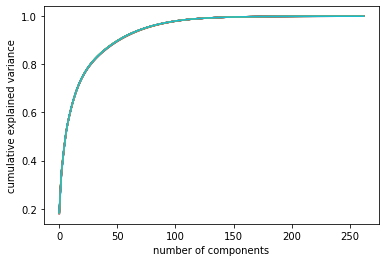

In [26]:
# Data loading functions
from adni.load_data import load_data 
data = load_data()
print(data.head())
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

""" 
kan dit weg?
#data_missing = data.isnull()
#print(data_missing.index[data_missing == True])
"""

# Creating vector of labels
data_no_label = data.drop(columns='label')
print(f'The number of features: {len(data_no_label.columns)}')
x = data_no_label
y = data['label']

# Split data in train and test set
#X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

# Check if there are NaN's
x_nan = np.isnan(x.values)
print(f'The number of found NaN is: {np.sum(x_nan)}')

# Remove features with only zero's as values
x_df = removezeros(x)
print(f'The number of features after removing zero-features: {len(x_df.columns)}')

# Get values of of the features
x = x_df.values

# Binarize the labels
#y_train_bin = label_binarize(y_train,['AD','CN'])
#y_train_bin = [i[0] for i in y_train_bin]
#y_test_bin = label_binarize(y_test,['AD','CN'])
#y_test_bin = [i[0] for i in y_test_bin]
y_bin = label_binarize(y,['AD','CN'])
y_bin = [i[0] for i in y_bin]
y_bin = np.array(y_bin)

# Repeat the experiment 20 times, use 20 random splits in which class balance is retained
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(x, y_bin):
    train_scores = []
    test_scores = []
    
    X_train = x[train_index]
    y_train = y_bin[train_index]
    X_test = x[test_index]
    y_test = y_bin[test_index]

    # Scaling of features
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection - L1 method
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
    selector.fit(X_train_scaled, y_train_bin)
    n_original = X_train_scaled.shape[1]
    X_train_test = selector.transform(X_train_scaled)
    n_selected = X_train_test.shape[1]
    print(f"Selected {n_selected} from {n_original} features with L1 method.")

    # PCA
    pca = PCA().fit(X_train_scaled)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');

    # Feature selection - PCA
    pca = PCA(n_components=n_selected)
    pca = pca.fit(X_train_scaled)
    X_train = pca.transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)

# Feature scaling and selection


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.7415993670088, tolerance: 0.0163421052631579
  positive)


Selected 132 from 263 features with L1 method.


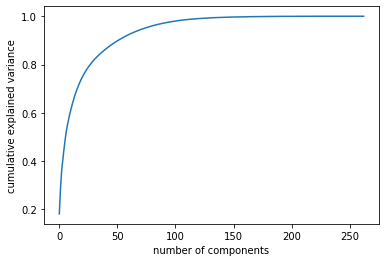

In [5]:
# Scaling of features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection - L1 method
selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_test = selector.transform(X_train_scaled)
n_selected = X_train_test.shape[1]
print(f"Selected {n_selected} from {n_original} features with L1 method.")

# PCA
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Feature selection - PCA
pca = PCA(n_components=132)
pca = pca.fit(X_train_scaled)
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

# SVM classifier
Hyperparameter optimization of SVM

In [6]:
 # Define hyperparameters for SVM 
SVM_param = {'C': loguniform(1e0, 1e3), 
              'gamma': loguniform(1e-4, 1e0), 
              'kernel': ['rbf','poly', 'linear']}  

# Perform randomized search with cross-validation for hyperparameter optimization
grid = RandomizedSearchCV(SVC(probability=True), SVM_param, n_iter=10, refit = True, verbose = 3, random_state=42) 
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.781, total=  15.4s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.759, total=   7.7s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.1s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.781, total=   9.7s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.693, total=   3.5s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.757, total=   5.2s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.796, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.788, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.796, total=   0.2s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.1min finished


The best classifier is:  SVC(C=4.335281794951563, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0005337032762603955, kernel='rbf', max_iter=-1, probability=True,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


ROC of SVM for train- and test-set

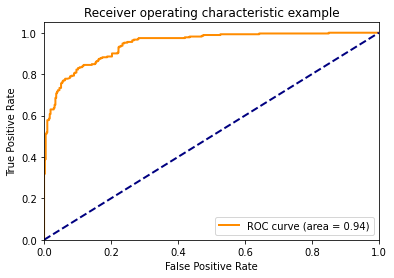

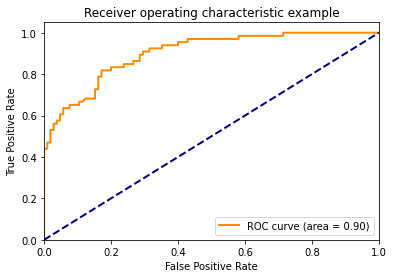

In [7]:
# Determine scores for train and test set
score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)

# Plot ROC curve for train and test set
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

Calculate metrics of SVM with cross-validation

In [8]:
# Preprocessing and feature selection on whole dataset
X_cv_df = removezeros(x)
X_cv_values = X_cv_df.values
X_cv_scaled = scaler.transform(X_cv_values)
X_cv = pca.transform(X_cv_scaled)

# Define the scoring metrics
scoring = ['precision', 'recall', 'f1', 'accuracy','roc_auc']

# Calculate the scores with cross-validation
scores = cross_validate(grid.best_estimator_, X_cv, y_bin, scoring=scoring, cv=20)

# Calculate the means of the score
mean_accuracy = mean(scores['test_accuracy'])
mean_precision = mean(scores['test_precision'])
mean_f1 = mean(scores['test_f1'])
mean_roc_auc = mean(scores['test_roc_auc'])
mean_recall = mean(scores['test_recall'])
print(f'mean accuracy is {mean_accuracy}')
print(f'mean precision is {mean_precision}')
print(f'mean f1 is {mean_f1}')
print(f'mean roc_auc is {mean_roc_auc}')
print(f'mean recall is {mean_recall}')

mean accuracy is 0.8153377630121816
mean precision is 0.8113404895757836
mean f1 is 0.7432344127899239
mean roc_auc is 0.8904558823529412
mean recall is 0.69375


# kNN classifier
Hyperparameter optimization of kNN

In [9]:
# Define hyperparameters for kNN
kNN_parameters = {'n_neighbors': list(range(1,101)), 
                   'weights':  ['uniform', 'distance'],
                   'metric': ['euclidean', 'manhattan']}

# Perform randomized search with cross-validation for hyperparameter optimization
grid = RandomizedSearchCV(KNeighborsClassifier(), kNN_parameters, refit = True, n_iter=10, random_state=42, verbose = 3)  
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.774, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.788, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.759, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.752, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.779, total=   0.0s
[CV] weights=uniform, n_neighbors=41, metric=manhattan ...............
[CV]  weights=uniform, n_neighbors=41, metric=manhattan, score=0.781, total=   0.0s
[CV] weig

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  weights=uniform, n_neighbors=41, metric=manhattan, score=0.737, total=   0.0s
[CV] weights=uniform, n_neighbors=41, metric=manhattan ...............
[CV]  weights=uniform, n_neighbors=41, metric=manhattan, score=0.781, total=   0.0s
[CV] weights=uniform, n_neighbors=41, metric=manhattan ...............
[CV]  weights=uniform, n_neighbors=41, metric=manhattan, score=0.737, total=   0.0s
[CV] weights=uniform, n_neighbors=41, metric=manhattan ...............
[CV]  weights=uniform, n_neighbors=41, metric=manhattan, score=0.757, total=   0.0s
[CV] weights=distance, n_neighbors=17, metric=euclidean ..............
[CV]  weights=distance, n_neighbors=17, metric=euclidean, score=0.781, total=   0.0s
[CV] weights=distance, n_neighbors=17, metric=euclidean ..............
[CV]  weights=distance, n_neighbors=17, metric=euclidean, score=0.788, total=   0.0s
[CV] weights=distance, n_neighbors=17, metric=euclidean ..............
[CV]  weights=distance, n_neighbors=17, metric=euclidean, score=0.79

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.6s finished


ROC of kNN for train- and test-set

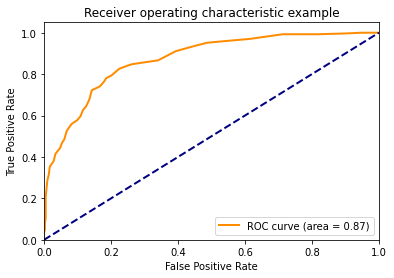

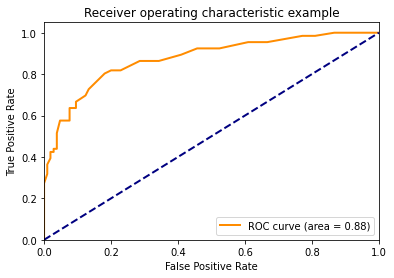

In [10]:
# Determine scores for train and test set
score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)

# Plot ROC curve for train and test set
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

Calculate metrics of kNN with cross-validation

In [11]:
# Preprocessing and feature selection on whole dataset
X_cv_df = removezeros(x)
X_cv_values = X_cv_df.values
X_cv_scaled = scaler.transform(X_cv_values)
X_cv = pca.transform(X_cv_scaled)

# Define the scoring metrics
scoring = ['precision', 'recall', 'f1', 'accuracy','roc_auc']

# Calculate the scores with cross-validation
scores = cross_validate(grid.best_estimator_, X_cv, y_bin, scoring=scoring, cv=20)

# Calculate the means of the score
mean_accuracy = mean(scores['test_accuracy'])
mean_precision = mean(scores['test_precision'])
mean_f1 = mean(scores['test_f1'])
mean_roc_auc = mean(scores['test_roc_auc'])
mean_recall = mean(scores['test_recall'])
print(f'mean accuracy is {mean_accuracy}')
print(f'mean precision is {mean_precision}')
print(f'mean f1 is {mean_f1}')
print(f'mean roc_auc is {mean_roc_auc}')
print(f'mean recall is {mean_recall}')

mean accuracy is 0.7837209302325582
mean precision is 0.7943764936044347
mean f1 is 0.6738259921654461
mean roc_auc is 0.8544283088235294
mean recall is 0.5957720588235295


# RF classifier
Hyperparameter optimization of RF

In [12]:
# Define hyperparameters for RF
forest_parameters = {'n_estimators': list(range(50,301)), 
                   'criterion':  ['gini', 'entropy'],
                   'max_depth': [4, 5, 6, 7, 8, 9, 10],
                   'max_features': ['auto','sqrt','log2']}

# Perform randomized search with cross-validation for hyperparameter optimization
grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, refit = True, n_iter=10, random_state=42, verbose = 3)  
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.737, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.774, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.781, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.737, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.743, total=   1.7s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.759, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.708, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.715, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.6s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=89,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


ROC of RF for train- and test-set

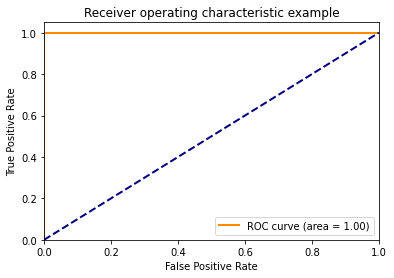

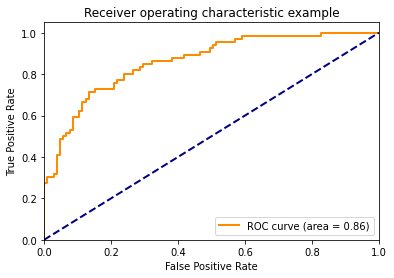

In [13]:
# Determine scores for train and test set
score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)

# Plot ROC curve for train and test set
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

Calculate metrics of RF with cross-validation

In [14]:
# Preprocessing and feature selection on whole dataset
X_cv_df = removezeros(x)
X_cv_values = X_cv_df.values
X_cv_scaled = scaler.transform(X_cv_values)
X_cv = pca.transform(X_cv_scaled)

# Define the scoring metrics
scoring = ['precision', 'recall', 'f1', 'accuracy','roc_auc']

# Calculate the scores with cross-validation
scores = cross_validate(grid.best_estimator_, X_cv, y_bin, scoring=scoring, cv=20)

# Calculate the means of the score
mean_accuracy = mean(scores['test_accuracy'])
mean_precision = mean(scores['test_precision'])
mean_f1 = mean(scores['test_f1'])
mean_roc_auc = mean(scores['test_roc_auc'])
mean_recall = mean(scores['test_recall'])
print(f'mean accuracy is {mean_accuracy}')
print(f'mean precision is {mean_precision}')
print(f'mean f1 is {mean_f1}')
print(f'mean roc_auc is {mean_roc_auc}')
print(f'mean recall is {mean_recall}')

mean accuracy is 0.7707918050941307
mean precision is 0.8246765040515041
mean f1 is 0.6392057154547844
mean roc_auc is 0.8506199095022624
mean recall is 0.5323529411764706
